<a href="https://colab.research.google.com/github/fxop0218/Tutorial-PyTorchForBeginners/blob/main/02_multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-classification for beginners


## Binary Classification
**🟦EN**: Binary classification is a type of machine learning task in which a label or class is assigned to a set of data. In binary classification, there are only two possible labels or classes that can be assigned to the data, usually labeled "positive" and "negative" or "1" and "0". The goal of the binary classification model is to predict the correct label for new data, based on patterns and features learned from training data. Common examples of binary classification applications include spam detection, disease identification and image classification.

**🟥ES**: La clasificación binaria es un tipo de tarea de aprendizaje automático en la que se asigna una etiqueta o clase a un conjunto de datos. En la clasificación binaria, hay solo dos posibles etiquetas o clases que se pueden asignar a los datos, generalmente etiquetadas como "positivo" y "negativo" o "1" y "0". El objetivo del modelo de clasificación binaria es predecir la etiqueta correcta para nuevos datos, en función de patrones y características aprendidos a partir de los datos de entrenamiento. Algunos ejemplos comunes de aplicaciones de la clasificación binaria incluyen la detección de spam, la identificación de enfermedades y la clasificación de imágenes.

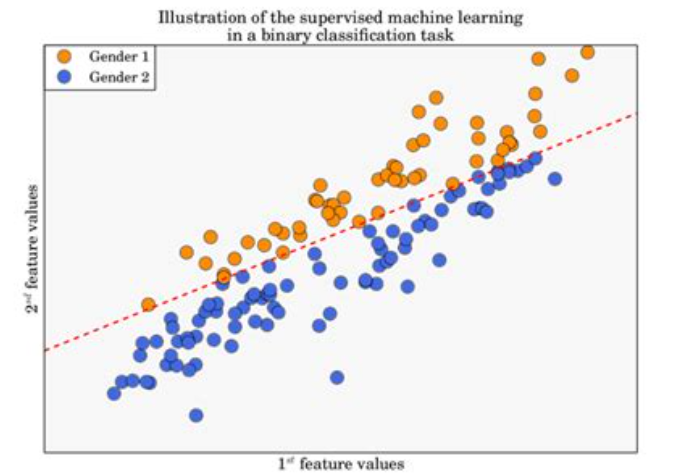

## Muli-classification
**🟦EN**: Multi-class classification is a machine learning task in which a label or class is assigned to a set of data, but unlike binary classification, there are more than two possible labels or classes that can be assigned to the data. Therefore, multiclass classification is suitable for problems where data must be classified into more than two different categories. In multiclass classification, the model must predict the correct label for new data based on patterns and features learned from the training data. Examples of multiclass classification applications include classifying images into different categories, classifying documents into different topics, and classifying products into different categories.

**🟥ES**: La clasificación multiclase es una tarea de aprendizaje automático en la que se asigna una etiqueta o clase a un conjunto de datos, pero a diferencia de la clasificación binaria, hay más de dos posibles etiquetas o clases que se pueden asignar a los datos. Por lo tanto, la clasificación multiclase es adecuada para problemas en los que se deben clasificar los datos en más de dos categorías diferentes. En la clasificación multiclase, el modelo debe predecir la etiqueta correcta para nuevos datos en función de patrones y características aprendidos a partir de los datos de entrenamiento. Algunos ejemplos de aplicaciones de la clasificación multiclase incluyen la clasificación de imágenes en diferentes categorías, la clasificación de documentos en diferentes temas y la clasificación de productos en diferentes categorías.

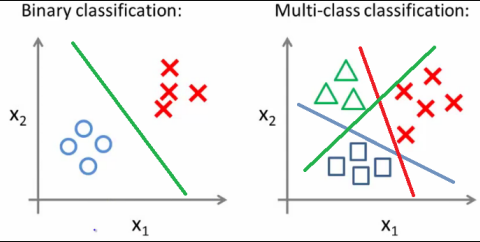

## 1 Creating dataset

**🟦EN**:
The first thing to do is to create a dataset to see the examples of multiple classifications.

**🟥ES**: 
Lo primero, es crear un dataset para ver los ejemplos de classificación multiple

In [ ]:
# Imports
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyperparameters
RANDOM_SEED = 10
NUM_CLASS = 4
NUM_FEATURES = 2

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
# Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000, 
                            centers = NUM_CLASS,
                            cluster_std=1.5, # controls the standard deviation of the Gaussian distributions that are used to generate the blobs. Specifically, center_std is a list of standard deviations for each of the blobs.
                            n_features = NUM_FEATURES,
                            random_state = RANDOM_SEED)

**🟦EN**:
Import helper functions

**🟥ES**: 
Importamos las funciones de ayuda

In [ ]:
# Import functions
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
# Turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float) 
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # If don't use LongTensro and use float, when using the loss function, an error will pop up

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, train_size=0.8)

print(f"X_train len: {len(X_train)} || X_test len: {len(X_test)} || y_train len: {len(y_train)} || y_test len: {len(y_test)}")

X_train len: 800 || X_test len: 200 || y_train len: 800 || y_test len: 200


**🟦EN**:
We show the data and how the classes are separated within a plane.

**🟥ES**: 
Mostramos los datos y como se separan las clases dentro de un plano

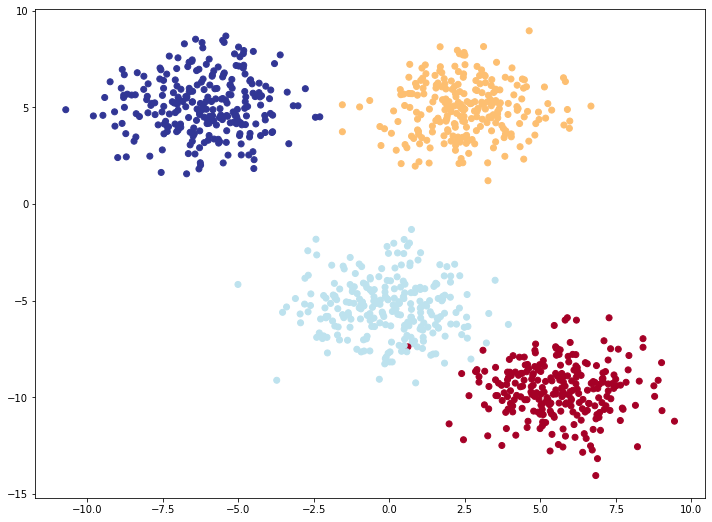

In [ ]:
# Plot data

plt.figure(figsize=(12, 9))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

## 2 Build multi-class PyTorch model

In [ ]:
# Agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [ ]:
from torch import nn
# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=20):
    """ INitializes multi-class classification model.
    Args: 
      Input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden units (int): Number of hidden units between layers, default 8

    Returns: 

    Exemple: 
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [ ]:
# Get the input and output dimensions

INPUT_DIM = len(X_train.shape)
OUT_DIM = len(y_train.unique()) # Different class types

print(f"Input len: {INPUT_DIM} || Output len: {OUT_DIM}")

Input len: 2 || Output len: 4


In [ ]:
model = BlobModel(input_features=INPUT_DIM,
                  output_features=OUT_DIM,
                  hidden_units=10).to(device)

print(f"Model info: {model}")

Model info: BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)


## 3. Create a loss function // optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.5)

## 4. Build a training loop

In [ ]:
model.eval()

with torch.inference_mode(): 
  y_logits = model(X_test.to(device))

print(f"Raw predictions: {y_logits[:5]} || wanted prediction: {y_test[:5]}")

Raw predictions: tensor([[ 0.0367, -0.0891,  0.2223,  0.2752],
        [ 0.0368, -0.0684,  0.2377,  0.2573],
        [-0.0476, -0.1579,  0.1170,  0.2161],
        [-0.1191, -0.2189, -0.0421,  0.1693],
        [ 0.0498, -0.0378,  0.2293,  0.2505]]) || wanted prediction: tensor([2, 2, 0, 0, 2])


#### Softmax activation formula

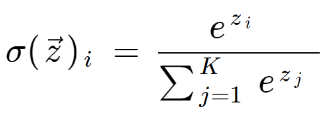

#### Softmax activation graph

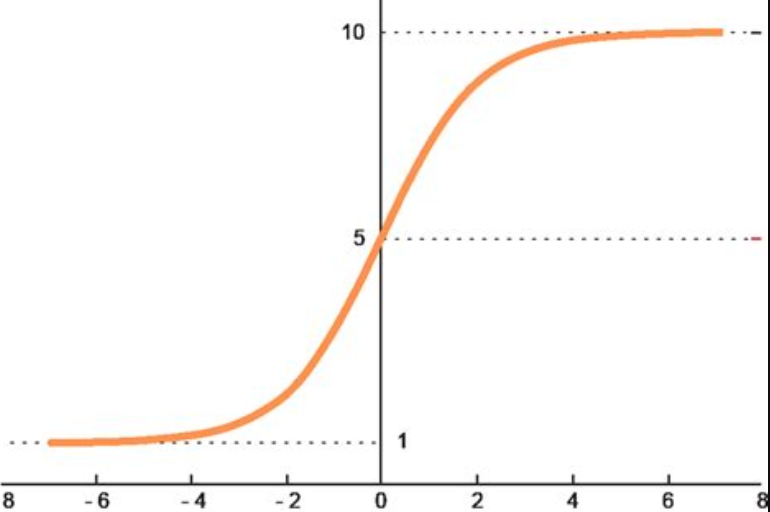

**🟦EN**:
Convert out model's prediction outputs into prediction probabilities.

**🟥ES**: 
Convertir los resultados de predicción del modelo en probabilidades de predicción.


In [ ]:
y_preds_probs = torch.softmax(y_logits, dim=1)
print(f"y_logits: {y_logits[:5]} || y_pred_probs: {y_preds_probs[:5]}")

y_logits: tensor([[ 0.0367, -0.0891,  0.2223,  0.2752],
        [ 0.0368, -0.0684,  0.2377,  0.2573],
        [-0.0476, -0.1579,  0.1170,  0.2161],
        [-0.1191, -0.2189, -0.0421,  0.1693],
        [ 0.0498, -0.0378,  0.2293,  0.2505]]) || y_pred_probs: tensor([[0.2296, 0.2025, 0.2765, 0.2915],
        [0.2289, 0.2060, 0.2798, 0.2853],
        [0.2285, 0.2046, 0.2694, 0.2974],
        [0.2315, 0.2095, 0.2501, 0.3089],
        [0.2307, 0.2113, 0.2760, 0.2820]])


**🟦EN**: The t_preds_probs represent the probability of belonging to one of the 4 classes, for this, we obtain the maximum value and put it in this class

**🟥ES**: Los t_preds_probs representan la probabilidad de pertenecer a una de las 4 clases, para ello, obtenemos el valor máximo y lo ponemos en esta clase


In [ ]:
print(f"First tensor: {y_preds_probs[0]}\nMax number of tensor: {torch.max(y_preds_probs[0]):.4f}\nClass to which it belongs: {torch.argmax(y_preds_probs[0])}")

First tensor: tensor([0.2296, 0.2025, 0.2765, 0.2915])
Max number of tensor: 0.2915
Class to which it belongs: 3


In [ ]:
y_preds = torch.argmax(y_preds_probs, dim = 1)
y_preds

tensor([3, 3, 3, 3, 3, 2, 2, 3, 0, 3, 3, 2, 3, 3, 0, 2, 3, 3, 2, 2, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 0,
        3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 2,
        0, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 0, 0, 0, 2, 3, 3, 3, 3, 3, 2, 3, 3, 0,
        2, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 0, 3, 0, 2, 2,
        3, 3, 3, 0, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 0, 3,
        2, 2, 3, 3, 2, 2, 2, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2,
        3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 3, 3,
        3, 3, 2, 3, 3, 2, 3, 3])

## 5. Getting predictions probabilities for a multi-class PyTorch model

**🟦EN**: In order to evaluate and train / test the model, we nned to convert le logits (output) to prediction probabilities and them to predicion labels

Raw output => prediction probabilities => Prediction labels

**🟥ES**: Para evaluar y entrenar/probar el modelo, necesitamos convertir los logits (resultados) en probabilidades de predicción y éstas en etiquetas de predicción.

Resultado bruto => probabilidades de predicción => etiquetas de predicción

In [ ]:
# Fit multi-class model

torch.manual_seed(10)
torch.cuda.manual_seed(10)
epochs = 500

# Target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
for epoch in range(epochs):
  model.train()
  
  # Make the raw prediction
  y_logits = model(X_train)

  # Get the prediction
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  # Caluclate the loss and the accuracity
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred=test_preds)
  
    # Print out what's happening
  if epoch % 50 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.39564, Acc: 22.50% | Test Loss: 5.69091, Test Acc: 33.00%
Epoch: 50 | Loss: 0.04995, Acc: 98.88% | Test Loss: 0.03462, Test Acc: 99.50%
Epoch: 100 | Loss: 0.01654, Acc: 99.62% | Test Loss: 0.03412, Test Acc: 99.50%
Epoch: 150 | Loss: 0.01635, Acc: 99.75% | Test Loss: 0.03514, Test Acc: 99.50%
Epoch: 200 | Loss: 0.01625, Acc: 99.75% | Test Loss: 0.03596, Test Acc: 99.50%
Epoch: 250 | Loss: 0.01616, Acc: 99.75% | Test Loss: 0.03671, Test Acc: 99.50%
Epoch: 300 | Loss: 0.01610, Acc: 99.75% | Test Loss: 0.03740, Test Acc: 99.50%
Epoch: 350 | Loss: 0.01709, Acc: 99.62% | Test Loss: 0.03808, Test Acc: 99.50%
Epoch: 400 | Loss: 0.01728, Acc: 99.62% | Test Loss: 0.03875, Test Acc: 99.50%
Epoch: 450 | Loss: 0.01731, Acc: 99.62% | Test Loss: 0.03941, Test Acc: 99.50%


## 6. Evaluate the predictions

In [ ]:
model.eval()

with torch.inference_mode():
  y_logits = model(X_test)

y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

**🟦EN**: We show how the classes are separated depending on the position in the plane.

**🟥ES**: Mostramos como se separan las classes dependiendo de la pocisción en el plano.

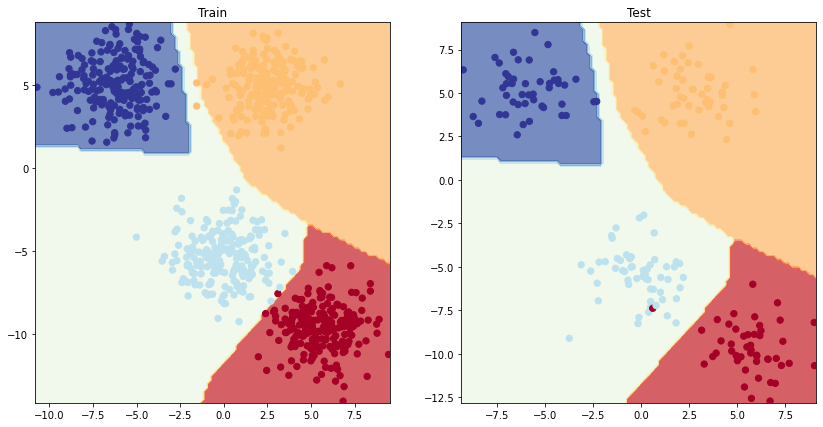

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

# 9. Classification metrics

**🟦EN**:
* Accuracy = out of 100 samples, how many does out model get right?
* Recall
* F1-Score
* Precision
* Confusión matrix
* Classification report

**🟥ES**:
* Accuracy = De 100 muestras, ¿cuántas acierta nuestro modelo?
* Recall
* F1-Score
* Precision
* Confusión matrix
* Classification report

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 9.5 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetrics_acc = Accuracy(task="multiclass", num_classes=OUT_DIM).to(device)

# Calculate
torchmetrics_acc(y_preds, y_test)

tensor(0.9950)